In [ ]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


## **Transfer learning**
 Transfer learning is  the practice of leveraging the knowledge gained by training a model on one task to accomplish a different but similar task. For example the model that was once trained to distinguish  types of bread was found to able to classify cancer cells from normals ones.

Transfer learning cuts down on the data  and computational power required  while finetuning the model as compared to what it would take to train one from  scratch.

 The introduction of transfer learning brought about a  paradigm shift in the approch to training deep networks. Transfer learning allows you to build  more powerful models with limitd data.
 This brought in the concept of pretraining models. Large models started being  trained on vast amounts of data  on some genralised task, for the sole purpose of being fine tuned  on down stream tasks.

 Platforms like pytorch, tensorflow, hugging face among many others provide access to thousands of pretrained Models  archirtectures and weights like  variants ResNet, DenseNet, Xception, Inception and VGG16.

 **Agenda:** - In this notebook we use the pretrained models form  keras.application library to study transfer learning. We use the model weights derived from trainined theses model on the famous ImageNet dataset. We use the same pipeline to train these three seperate models with same configurations and data inputs. we build a cat vs dog classifier to using Xception, VGG16 and ResNet. In the end we discuss the results.


**steps to perform transfer learning**


1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during
 future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn
 the old features into predictions on a  new dataset.
4. Train the new layers on your dataset.



In [ ]:
#  the following couple blocks of code demonstrates how you could freeze  the layer

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In [ ]:
layer.weights

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.42877573,  0.41026747,  0.569384  ],
        [-0.89724094, -0.56840944,  0.03870285],
        [ 0.44560885, -0.60229594,  0.264336  ],
        [-0.08385766, -0.4180159 ,  0.11744082]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


you can note that freezing the layers by setting  the `layer.trainable `  = False reduces the count of trainable weights.

now lets build a Xception model here

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

##Preparing the data

We import the data from the tensorflow_datasets and prepare our train test data splits

In [ ]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


Here is a sample of our data set along with their labels

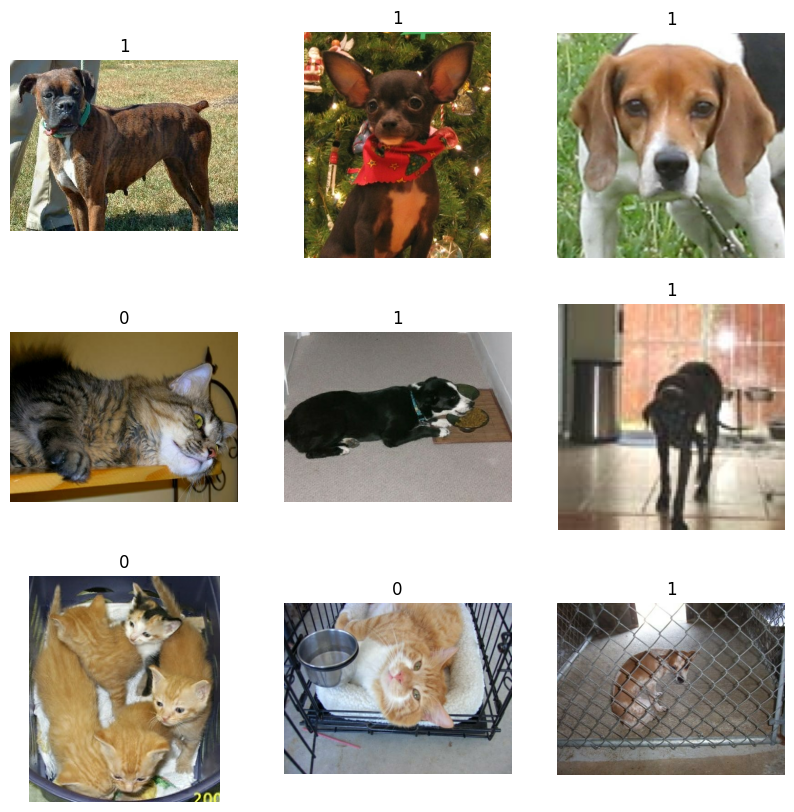

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

the label 1 is assigned to dog and 0 to cat

 you  resize and standardize the data.

In [ ]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

We perform data augmentation which allows the model to genralise better and avoid overfitting, while increasing the size of our dataset.

In [ ]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

you perform batching and prefetching to improve the model performance.

In [ ]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

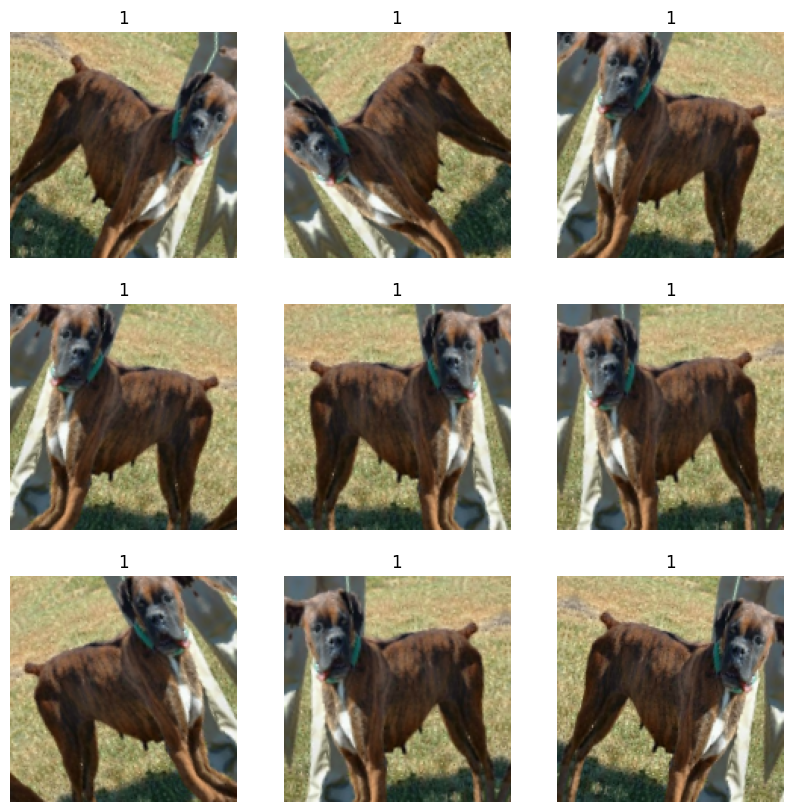

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# **Model training and finetuning**

## Xception

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0   

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 [==============================] - 62s 360ms/step - loss: 0.1891 - binary_accuracy: 0.9179 - val_loss: 0.0896 - val_binary_accuracy: 0.9673
Epoch 2/2
146/146 [==============================] - 20s 135ms/step - loss: 0.1166 - binary_accuracy: 0.9515 - val_loss: 0.0806 - val_binary_accuracy: 0.9690


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0   

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 [==============================] - 5s 108ms/step - loss: 0.0837 - binary_accuracy: 0.9669


[0.08371976017951965, 0.9668959379196167]

## ResNet50

In [ ]:
base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 resnet50 (Functional)       (None, 5, 5, 2048)        2358771   N          
                                                       2                    
                                                                            
 global_average_pooling2d_3  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                       

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
146/146 [==============================] - 21s 119ms/step - loss: 0.6557 - binary_accuracy: 0.5593 - val_loss: 0.6456 - val_binary_accuracy: 0.6281
Epoch 2/10
146/146 [==============================] - 17s 113ms/step - loss: 0.6487 - binary_accuracy: 0.5764 - val_loss: 0.6383 - val_binary_accuracy: 0.6333
Epoch 3/10
146/146 [==============================] - 17s 115ms/step - loss: 0.6448 - binary_accuracy: 0.5824 - val_loss: 0.6344 - val_binary_accuracy: 0.6414
Epoch 4/10
146/146 [==============================] - 17s 115ms/step - loss: 0.6416 - binary_accuracy: 0.5841 - val_loss: 0.6305 - val_binary_accuracy: 0.6513
Epoch 5/10
146/146 [==============================] - 17s 116ms/step - loss: 0.6361 - binary_accuracy: 0.5930 - val_loss: 0.6265 - val_binary_accuracy: 0.6582
Epoch 6/10
146/146 [==============================] - 17s 118ms/step - loss: 0.6344 - binary_accuracy: 0.6021 - val_loss: 0.6246 - val_binary_accuracy: 0.6608
Epoch 7/10


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 [==============================] - 3s 89ms/step - loss: 0.6501 - binary_accuracy: 0.6191


[0.6501182317733765, 0.6190885901451111]

## VGG16

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 vgg16 (Functional)          (None, 4, 4, 512)         1471468   N          
                                                       8                    
                                                                            
 global_average_pooling2d_4  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                       

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
146/146 [==============================] - 38s 211ms/step - loss: 0.5468 - binary_accuracy: 0.6850 - val_loss: 0.3823 - val_binary_accuracy: 0.8710
Epoch 2/10
146/146 [==============================] - 22s 152ms/step - loss: 0.4019 - binary_accuracy: 0.8158 - val_loss: 0.2998 - val_binary_accuracy: 0.8904
Epoch 3/10
146/146 [==============================] - 22s 152ms/step - loss: 0.3469 - binary_accuracy: 0.8430 - val_loss: 0.2632 - val_binary_accuracy: 0.9041
Epoch 4/10
146/146 [==============================] - 22s 152ms/step - loss: 0.3191 - binary_accuracy: 0.8551 - val_loss: 0.2428 - val_binary_accuracy: 0.9093
Epoch 5/10
146/146 [==============================] - 23s 155ms/step - loss: 0.3017 - binary_accuracy: 0.8647 - val_loss: 0.2297 - val_binary_accuracy: 0.9157
Epoch 6/10
146/146 [==============================] - 23s 157ms/step - loss: 0.2936 - binary_accuracy: 0.8689 - val_loss: 0.2175 - val_binary_accuracy: 0.9179
Epoch 7/10


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 vgg16 (Functional)          (None, 4, 4, 512)         1471468   Y          
                                                       8                    
                                                                            
 global_average_pooling2d_4  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_3 (Dropout)         (None, 512)               0   

Final Remarks -